In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import cooltools
from cooltools import insulation

In [3]:
cool_file = "/Users/xl5525/Documents/mcool/larval_brain_merge.mcool"
cool_file2 = "/Users/xl5525/Documents/mcool/cg11504.merged.mcool"
cool_file3 = "/Users/xl5525/Documents/mcool/POZ_larval_brain_merge.mcool"

In [4]:
resolution = 1600
clr = cooler.Cooler(f'{cool_file}::resolutions/{resolution}')
clr2 = cooler.Cooler(f'{cool_file2}::resolutions/{resolution}')
clr3 = cooler.Cooler(f'{cool_file3}::resolutions/{resolution}')

windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)
insulation_table2 = insulation(clr2, windows, verbose=True)
insulation_table3 = insulation(clr3, windows, verbose=True)

INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Processing region chr3R
INFO:root:Processing region chr4
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Processing region chr3R
INFO:root:Processing region chr4
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM
INFO:root:fallback to serial implementation.
INFO:root:Processing region chr2L
INFO:root:Processing region chr2R
INFO:root:Processing region chr3L
INFO:root:Processing region chr3R
INFO:root:Processing region chr4
INFO:root:Processing region chrX
INFO:root:Processing region chrY
INFO:root:Processing region chrM


In [5]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [6]:
from pygenometracks.tracksClass import PlotTracks
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

In [7]:
start = 12_776_000
end = 12_901_000
region = ('chr2L', start, end)
region_name = 'kek1'
norm = LogNorm(vmax=0.1, vmin=0.001)

# Fetch the matrix for both Hi-C datasets
data = clr.matrix(balance=True).fetch(region)
data2 = clr2.matrix(balance=True).fetch(region)
data3 = clr3.matrix(balance=True).fetch(region)

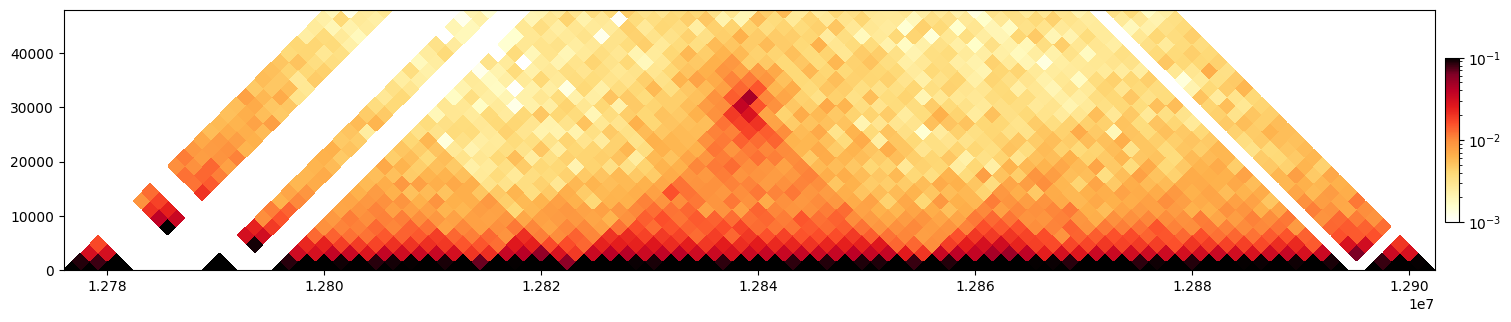

In [8]:
%matplotlib inline

# Create a figure with three subplots
fig, ax1 = plt.subplots(figsize=(18, 12))

# Plot the first heatmap (top panel)
im1 = pcolormesh_45deg(ax1, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax1.set_aspect(0.5)
ax1.set_ylim(0, 10 * windows[0])

# Add a colorbar for the first heatmap
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im1, cax=cax1)

# Save the first heatmap plot
plt.savefig(f'{region_name}_yw.png', dpi=300, bbox_inches='tight')

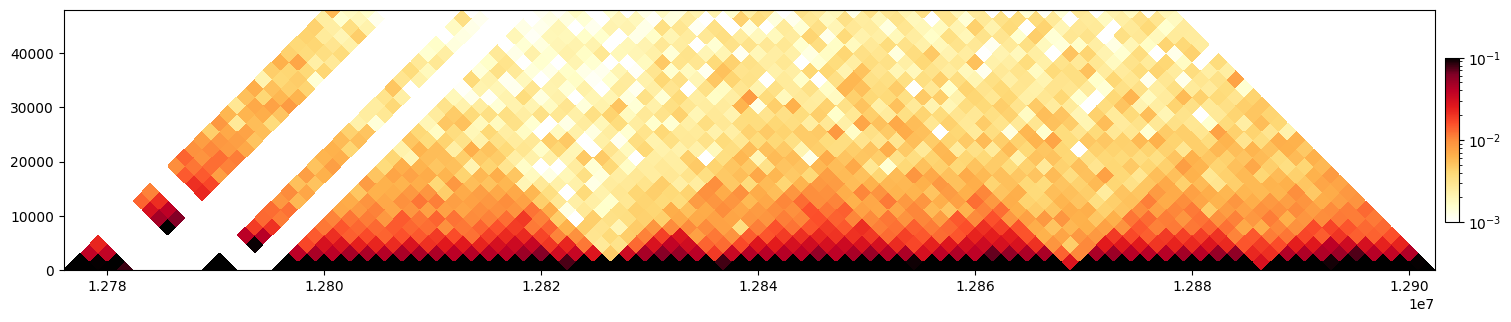

In [9]:
# Plot the second heatmap (middle panel)
fig, ax2 = plt.subplots(figsize=(18, 12))
im2 = pcolormesh_45deg(ax2, data2, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax2.set_aspect(0.5)
ax2.set_ylim(0, 10 * windows[0])

# Add a colorbar for the second heatmap
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im2, cax=cax2)

# Save the second heatmap plot
plt.savefig(f'{region_name}_cg11504.png', dpi=300, bbox_inches='tight')

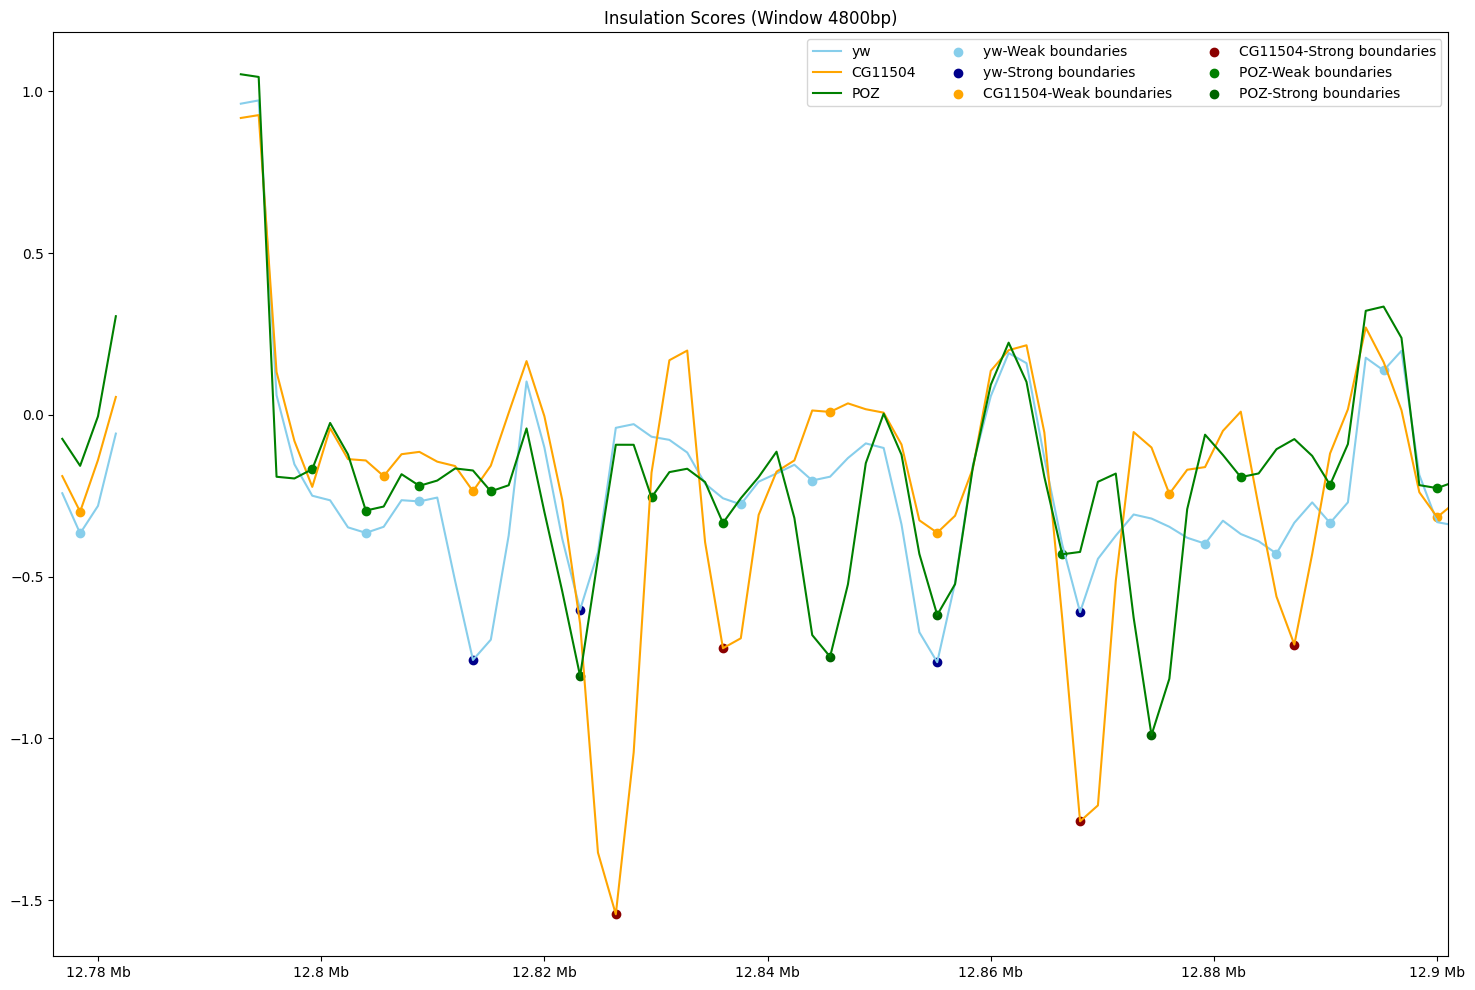

In [10]:
fig, ax3 = plt.subplots(figsize=(18, 12))
# Plot the insulation score in the bottom panel
insul_region = bioframe.select(insulation_table, region)
insul_region2 = bioframe.select(insulation_table2, region)
insul_region3 = bioframe.select(insulation_table3, region)

ax3.plot(insul_region[['start', 'end']].mean(axis=1),
         insul_region[f'log2_insulation_score_{windows[0]}'], label='yw', color='skyblue')
ax3.plot(insul_region2[['start', 'end']].mean(axis=1),
         insul_region2[f'log2_insulation_score_{windows[0]}'], label='CG11504', color='orange')
ax3.plot(insul_region3[['start', 'end']].mean(axis=1),
         insul_region3[f'log2_insulation_score_{windows[0]}'], label='POZ', color='green')

# Highlight weak and strong boundaries for both samples
boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]

boundaries2 = insul_region2[~np.isnan(insul_region2[f'boundary_strength_{windows[0]}'])]
weak_boundaries2 = boundaries2[~boundaries2[f'is_boundary_{windows[0]}']]
strong_boundaries2 = boundaries2[boundaries2[f'is_boundary_{windows[0]}']]

boundaries3 = insul_region3[~np.isnan(insul_region3[f'boundary_strength_{windows[0]}'])]
weak_boundaries3 = boundaries3[~boundaries3[f'is_boundary_{windows[0]}']]
strong_boundaries3 = boundaries3[boundaries3[f'is_boundary_{windows[0]}']]
# Scatter plot for boundaries (both samples)
ax3.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='yw-Weak boundaries', color='skyblue')
ax3.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='yw-Strong boundaries', color='darkblue')

ax3.scatter(weak_boundaries2[['start', 'end']].mean(axis=1),
            weak_boundaries2[f'log2_insulation_score_{windows[0]}'], label='CG11504-Weak boundaries', color='orange')
ax3.scatter(strong_boundaries2[['start', 'end']].mean(axis=1),
            strong_boundaries2[f'log2_insulation_score_{windows[0]}'], label='CG11504-Strong boundaries', color='darkred')


ax3.scatter(weak_boundaries3[['start', 'end']].mean(axis=1),
            weak_boundaries3[f'log2_insulation_score_{windows[0]}'], label='POZ-Weak boundaries', color='green')
ax3.scatter(strong_boundaries3[['start', 'end']].mean(axis=1),
            strong_boundaries3[f'log2_insulation_score_{windows[0]}'], label='POZ-Strong boundaries', color='darkgreen')

# Add legend and format ticks
ax3.legend(loc='upper right', ncol=3)
format_ticks(ax3, y=False, rotate=False)
ax3.set_xlim(region[1], region[2])
ax3.set_title("Insulation Scores (Window 4800bp)")

# Save the insulation score plot
plt.savefig(f'{region_name}_insulation_scores_cg.png', dpi=300, bbox_inches='tight')

In [15]:
# Select rows with defined boundary strength and filter for strong boundaries genome-wide
boundaries_yw = insulation_table[~np.isnan(insulation_table[f'boundary_strength_{windows[0]}'])]
strong_boundaries_yw = boundaries_yw[boundaries_yw[f'is_boundary_{windows[0]}']]

boundaries_cg = insulation_table2[~np.isnan(insulation_table2[f'boundary_strength_{windows[0]}'])]
strong_boundaries_cg = boundaries_cg[boundaries_cg[f'is_boundary_{windows[0]}']]

# List to store new strong boundaries (CG11504 that don't overlap any yw strong boundaries)
new_strong_boundaries_genome = []

# Get the unique chromosomes present in CG11504 data
chromosomes = strong_boundaries_cg['chrom'].unique()

for chrom in chromosomes:
    # Select boundaries on the current chromosome for each sample
    cg_chr = strong_boundaries_cg[strong_boundaries_cg['chrom'] == chrom]
    yw_chr = strong_boundaries_yw[strong_boundaries_yw['chrom'] == chrom]
    
    # Iterate over each CG11504 strong boundary on this chromosome
    for idx, cg_bound in cg_chr.iterrows():
        # Overlap check: Two intervals [start1, end1] and [start2, end2] overlap if:
        # start1 <= end2 and end1 >= start2.
        overlapping = yw_chr[
            (yw_chr['start'] <= cg_bound['end']) &
            (yw_chr['end'] >= cg_bound['start'])
        ]
        # If no overlapping boundary is found, record this as a new strong boundary
        if overlapping.empty:
            new_strong_boundaries_genome.append(cg_bound)

# Convert the list to a DataFrame for further analysis or export
new_strong_boundaries_df = pd.DataFrame(new_strong_boundaries_genome)

# Optionally, get a list of coordinate tuples (chrom, start, end) for the new boundaries
new_boundaries_list = list(new_strong_boundaries_df[['chrom', 'start', 'end']].itertuples(index=False, name=None))

print("New strong boundaries in CG11504 (genome-wide, compared to yw):")
print(new_boundaries_list)
new_strong_boundaries_df.to_csv('new_strong_boundaries_cg11504_vs_yw.csv', index=False, sep = '\t')


New strong boundaries in CG11504 (genome-wide, compared to yw):
[('chr2L', 43200, 44800), ('chr2L', 270400, 272000), ('chr2L', 337600, 339200), ('chr2L', 430400, 432000), ('chr2L', 558400, 560000), ('chr2L', 633600, 635200), ('chr2L', 777600, 779200), ('chr2L', 1118400, 1120000), ('chr2L', 1256000, 1257600), ('chr2L', 1318400, 1320000), ('chr2L', 1483200, 1484800), ('chr2L', 1502400, 1504000), ('chr2L', 1518400, 1520000), ('chr2L', 1649600, 1651200), ('chr2L', 1768000, 1769600), ('chr2L', 1825600, 1827200), ('chr2L', 1908800, 1910400), ('chr2L', 1926400, 1928000), ('chr2L', 1995200, 1996800), ('chr2L', 2088000, 2089600), ('chr2L', 2161600, 2163200), ('chr2L', 2219200, 2220800), ('chr2L', 2259200, 2260800), ('chr2L', 2449600, 2451200), ('chr2L', 2500800, 2502400), ('chr2L', 2635200, 2636800), ('chr2L', 2835200, 2836800), ('chr2L', 2916800, 2918400), ('chr2L', 3422400, 3424000), ('chr2L', 3440000, 3441600), ('chr2L', 3470400, 3472000), ('chr2L', 3480000, 3481600), ('chr2L', 3539200, 3540


INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [dmel-all-r6.59]

100%|██████████| 32/32 [00:00<00:00, 3712.29it/s]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.36741018295288086
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 7.9787234042553195. Dpi is set to 300

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [dmel-all-r6.59]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08


NameError: name 'xlim' is not defined

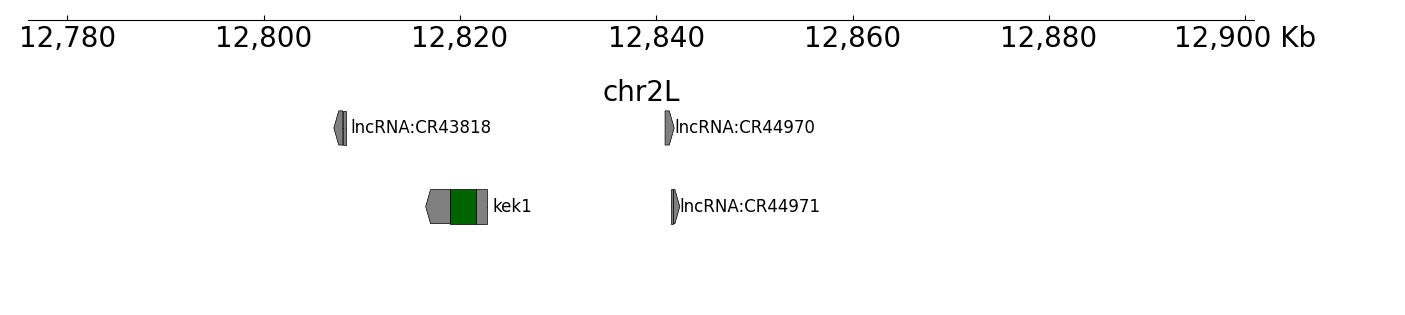

In [12]:
trp = PlotTracks("tracks_genome_simplified.ini", plot_regions=[region], dpi=300)


# Call the plot method with the required parameters and set the same x-limits
trp.plot(f'{region_name}_genome_region', region[0], region[1], region[2])

# Set the x-limits for the PlotTracks plot to match the main plot
plt.xlim(xlim)

# Show the plot
plt.show()